# 🫀 Heart Disease — Data Cleaning + EDA
**Kaggle Playground Series S6E2**

### Workflow
1. Load data
2. Data cleaning & quality checks
3. EDA (post-cleaning)
4. Gender-stratified analysis → do we need separate models?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plot style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120

# ── Paths ──────────────────────────────────────────────────────────────────
BASE = '/users/clairedebadts/kaggle/heart-disease-playground/data/'
train = pd.read_csv(BASE + 'train.csv')
test  = pd.read_csv(BASE + 'test.csv')

print(f'Train: {train.shape}  |  Test: {test.shape}')
train.head(3)

Train: (630000, 15)  |  Test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence


---
## 1 · Raw Data Snapshot

In [2]:
print('=== DTYPES ===')
print(train.dtypes)
print('\n=== DESCRIBE (numerics) ===')
train.describe()

=== DTYPES ===
id                           int64
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease               object
dtype: object

=== DESCRIBE (numerics) ===


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [3]:
print('=== DESCRIBE (objects / categoricals) ===')
train.describe(include='object')

=== DESCRIBE (objects / categoricals) ===


,Heart Disease
count,630000
unique,2
top,Absence
freq,347546


---
## 2 · Data Cleaning

### 2.1 · Missing values

In [4]:
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing, 'missing_%': missing_pct})
missing_df = missing_df[missing_df.missing_count > 0]

if missing_df.empty:
    print('✅ No missing values in train set.')
else:
    print(missing_df)
    # Visualise
    fig, ax = plt.subplots(figsize=(10, 4))
    missing_df['missing_%'].plot(kind='bar', ax=ax, color='salmon')
    ax.set_title('Missing values (%)')
    plt.tight_layout()
    plt.show()

✅ No missing values in train set.


### 2.2 · Duplicate rows

In [5]:
feature_cols = [c for c in train.columns if c not in ['id', 'Heart Disease']]
dups = train.duplicated(subset=feature_cols).sum()
print(f'Duplicate feature rows (ignoring id/target): {dups}  ({dups/len(train)*100:.2f}%)')

Duplicate feature rows (ignoring id/target): 0  (0.00%)


### 2.3 · Target encoding
Convert `Heart Disease` from `Presence`/`Absence` → 1/0

In [6]:
# Check raw values first
print('Target unique values:', train['Heart Disease'].unique())

target_map = {'Presence': 1, 'Absence': 0}
train['target'] = train['Heart Disease'].map(target_map)

print('After encoding:', train['target'].value_counts())
print(f'Positive rate: {train["target"].mean():.1%}')

Target unique values: ['Presence' 'Absence']
After encoding: target
0    347546
1    282454
Name: count, dtype: int64
Positive rate: 44.8%


### 2.4 · Outlier detection (IQR method)

In [7]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['id', 'target']]

outlier_summary = []
for col in numeric_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 3 * IQR, Q3 + 3 * IQR  # 3×IQR = extreme outliers
    n_out = ((train[col] < lower) | (train[col] > upper)).sum()
    outlier_summary.append({'feature': col, 'lower_fence': round(lower,2),
                             'upper_fence': round(upper,2), 'n_extreme_outliers': n_out,
                             'pct': round(n_out/len(train)*100, 3)})

outlier_df = pd.DataFrame(outlier_summary).sort_values('n_extreme_outliers', ascending=False)
print(outlier_df.to_string(index=False))

                feature  lower_fence  upper_fence  n_extreme_outliers   pct
           FBS over 120          0.0          0.0               50392 7.999
            Cholesterol         85.0        407.0                 243 0.039
          ST depression         -4.2          5.6                 141 0.022
                    Age         12.0         96.0                   0 0.000
                    Sex         -3.0          4.0                   0 0.000
        Chest pain type          0.0          7.0                   0 0.000
                     BP         60.0        200.0                   0 0.000
            EKG results         -6.0          8.0                   0 0.000
                 Max HR         70.0        238.0                   0 0.000
        Exercise angina         -3.0          4.0                   0 0.000
            Slope of ST         -2.0          5.0                   0 0.000
Number of vessels fluro         -3.0          4.0                   0 0.000
            

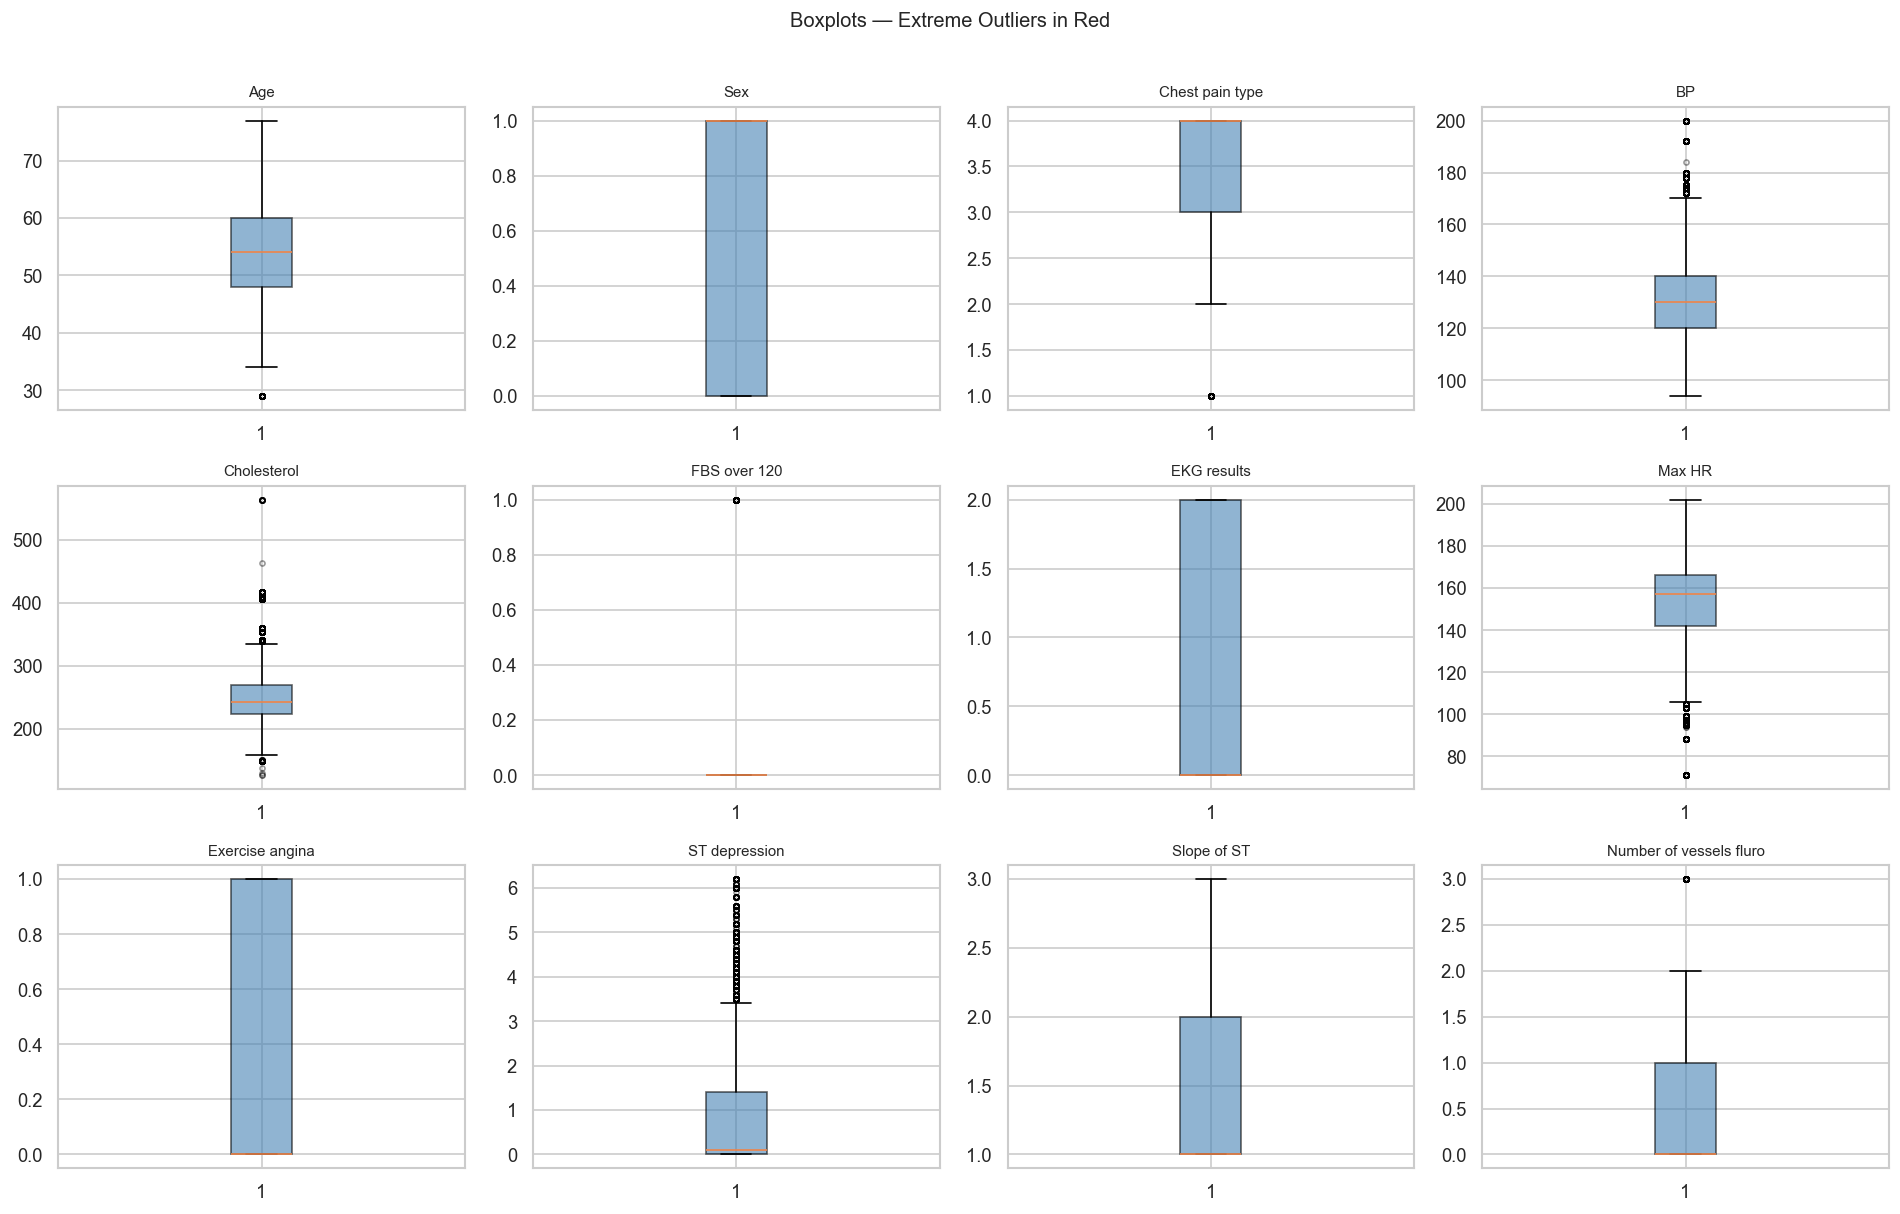

In [8]:
# Visualise with boxplots — flag outliers
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:12]):
    axes[i].boxplot(train[col].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.6),
                    flierprops=dict(marker='o', color='tomato', alpha=0.4, markersize=3))
    axes[i].set_title(col, fontsize=9)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Boxplots — Extreme Outliers in Red', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

### 2.5 · Impossible / domain-invalid values

In [9]:
# Domain rules for heart disease dataset
domain_checks = {
    'Age':                   (18, 110),
    'BP':                    (60, 250),
    'Cholesterol':           (0, 600),
    'Max HR':                (50, 220),
    'ST depression':         (0, 10),
    'FBS over 120':          (0, 1),
    'EKG results':           (0, 2),
    'Exercise angina':       (0, 1),
    'Slope of ST':           (1, 3),
    'Number of vessels fluro': (0, 3),
    'Thallium':              (3, 7),
    'Chest pain type':       (1, 4),
}

for col, (lo, hi) in domain_checks.items():
    if col in train.columns:
        n = ((train[col] < lo) | (train[col] > hi)).sum()
        if n > 0:
            print(f'⚠️  {col}: {n} values outside [{lo}, {hi}]')
            print(train[col][(train[col] < lo) | (train[col] > hi)].value_counts().head())
        else:
            print(f'✅  {col}: all values in [{lo}, {hi}]')

✅  Age: all values in [18, 110]
✅  BP: all values in [60, 250]
✅  Cholesterol: all values in [0, 600]
✅  Max HR: all values in [50, 220]
✅  ST depression: all values in [0, 10]
✅  FBS over 120: all values in [0, 1]
✅  EKG results: all values in [0, 2]
✅  Exercise angina: all values in [0, 1]
✅  Slope of ST: all values in [1, 3]
✅  Number of vessels fluro: all values in [0, 3]
✅  Thallium: all values in [3, 7]
✅  Chest pain type: all values in [1, 4]


### 2.6 · Categorical value standardisation

In [10]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
cat_cols = [c for c in cat_cols if c not in ['Heart Disease']]

for col in cat_cols:
    print(f'\n--- {col} ---')
    print(train[col].value_counts())

### 2.7 · Clean dataset ready ✅

In [11]:
# Drop original target string column, keep encoded
df = train.drop(columns=['Heart Disease']).copy()

# Optional: clip extreme outliers to fence values (uncomment if needed)
# for col in numeric_cols:
#     Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     df[col] = df[col].clip(Q1 - 3*IQR, Q3 + 3*IQR)

print(f'Clean train shape: {df.shape}')
print(f'Target distribution:\n{df["target"].value_counts()}')

Clean train shape: (630000, 15)
Target distribution:
target
0    347546
1    282454
Name: count, dtype: int64


---
## 3 · EDA (Post-Cleaning)

### 3.1 · Target distribution

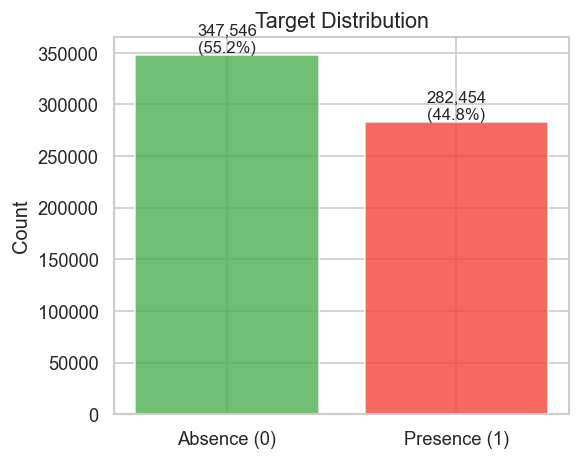

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
counts = df['target'].value_counts()
bars = ax.bar(['Absence (0)', 'Presence (1)'], counts.values,
               color=['#4CAF50', '#F44336'], alpha=0.8, edgecolor='white')
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{count:,}\n({count/len(df)*100:.1f}%)', ha='center', va='bottom', fontsize=10)
ax.set_title('Target Distribution', fontsize=13)
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### 3.2 · Numeric feature distributions by target

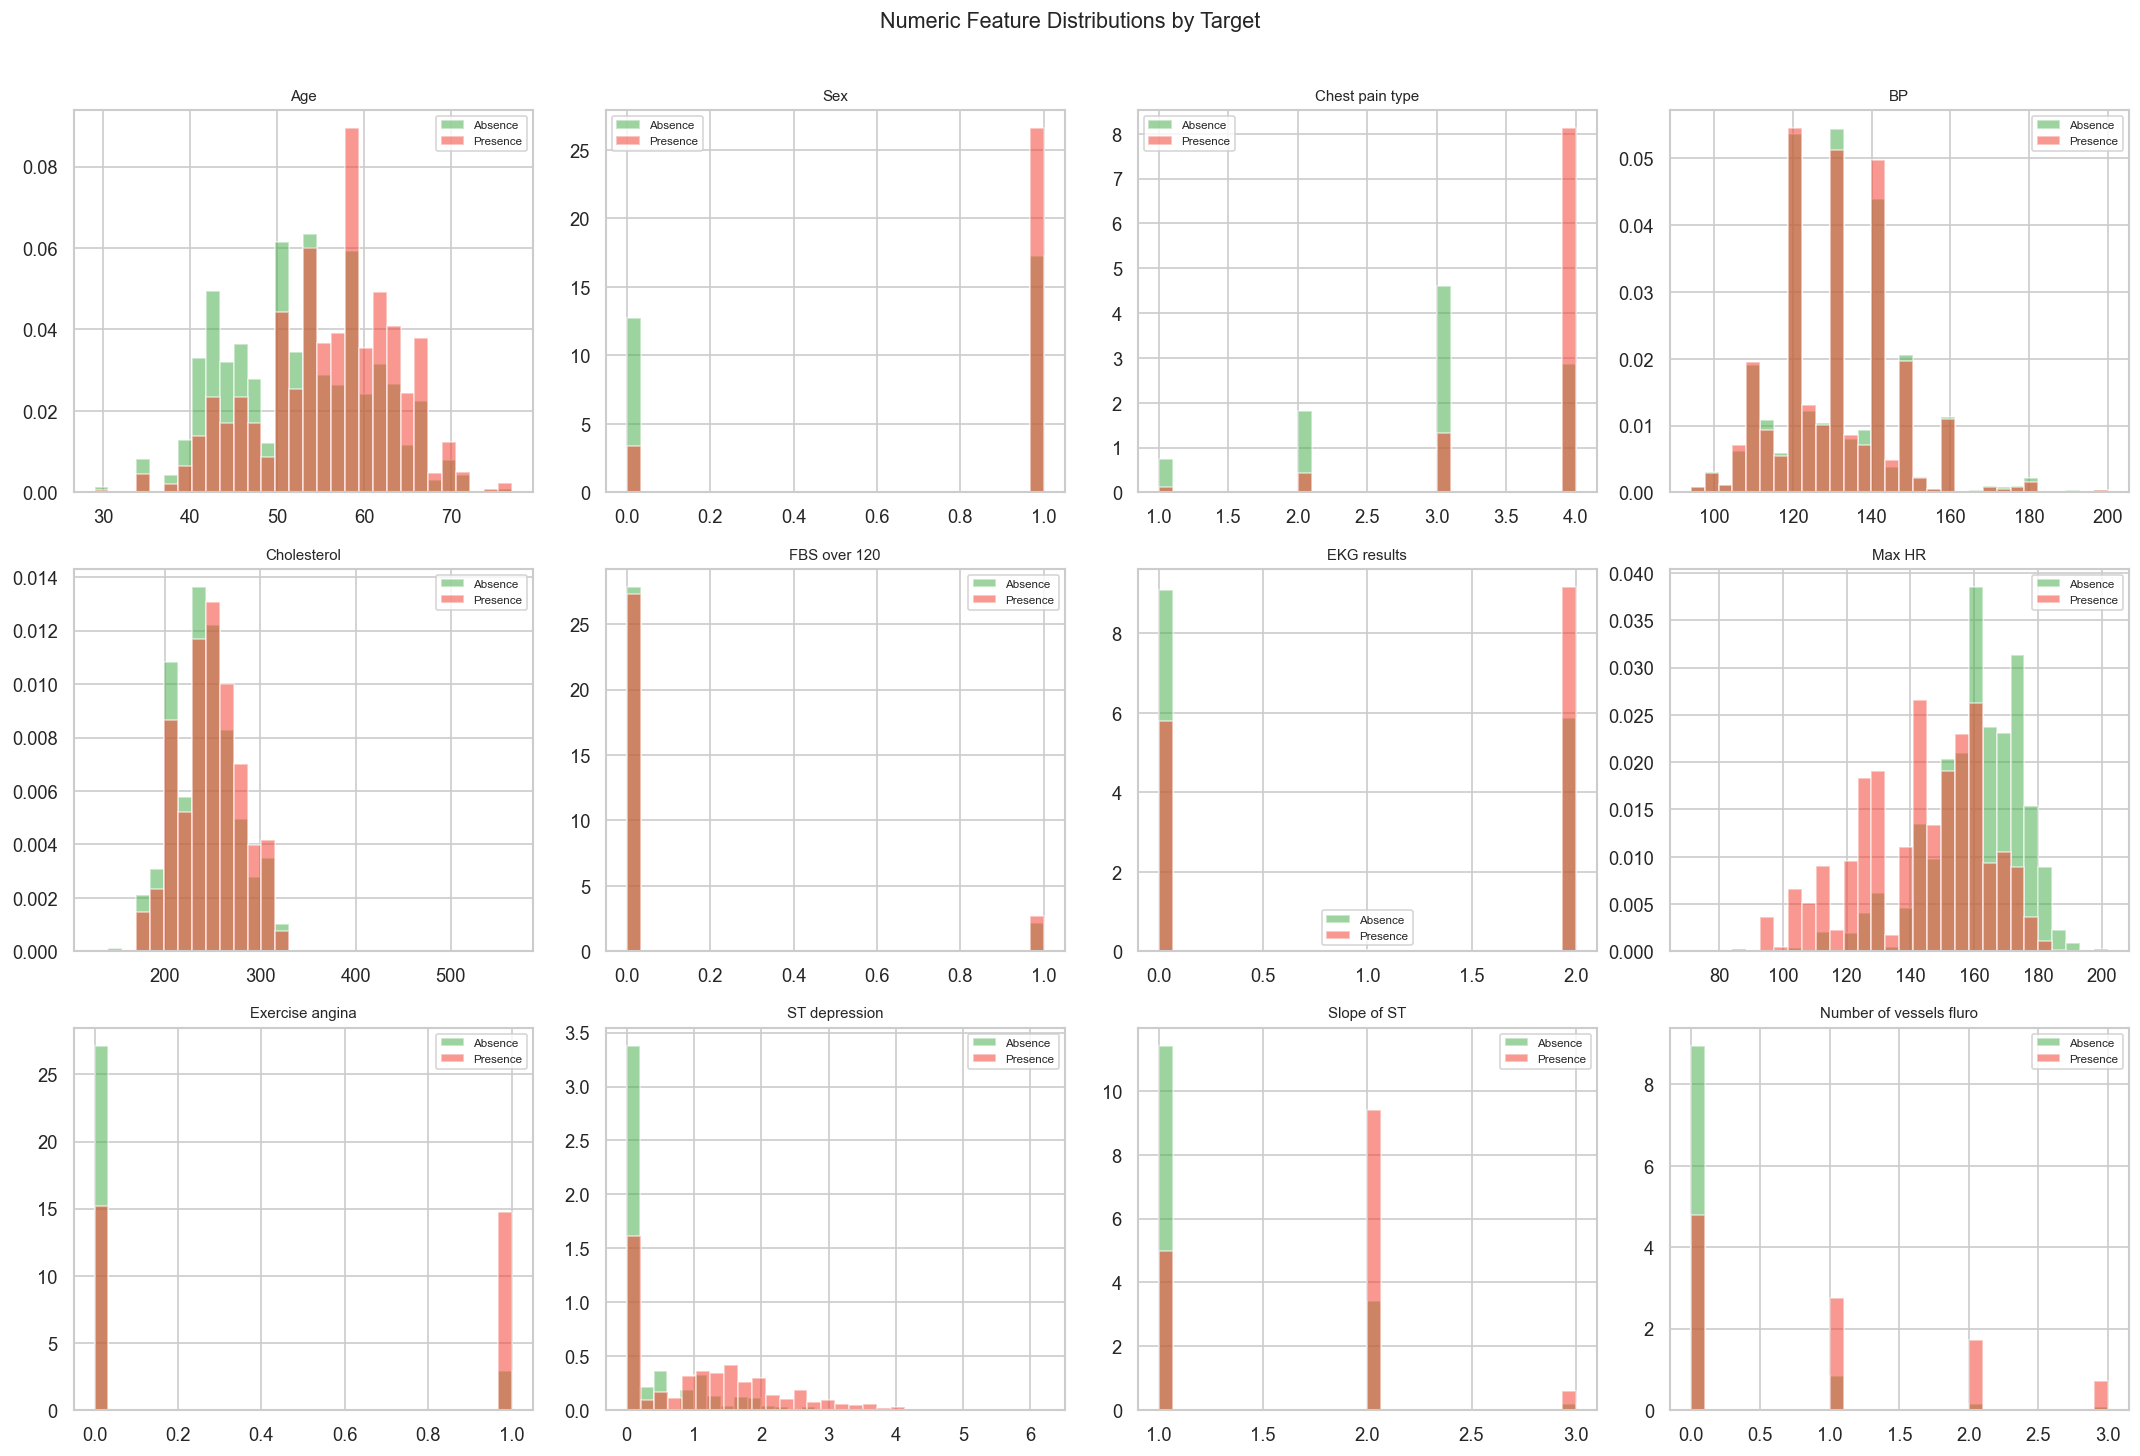

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()
colors = {0: '#4CAF50', 1: '#F44336'}

for i, col in enumerate(numeric_cols[:12]):
    for tgt, grp in df.groupby('target'):
        axes[i].hist(grp[col].dropna(), bins=30, alpha=0.55,
                     color=colors[tgt], label='Absence' if tgt==0 else 'Presence', density=True)
    axes[i].set_title(col, fontsize=9)
    axes[i].legend(fontsize=7)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Numeric Feature Distributions by Target', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

### 3.3 · Correlation heatmap

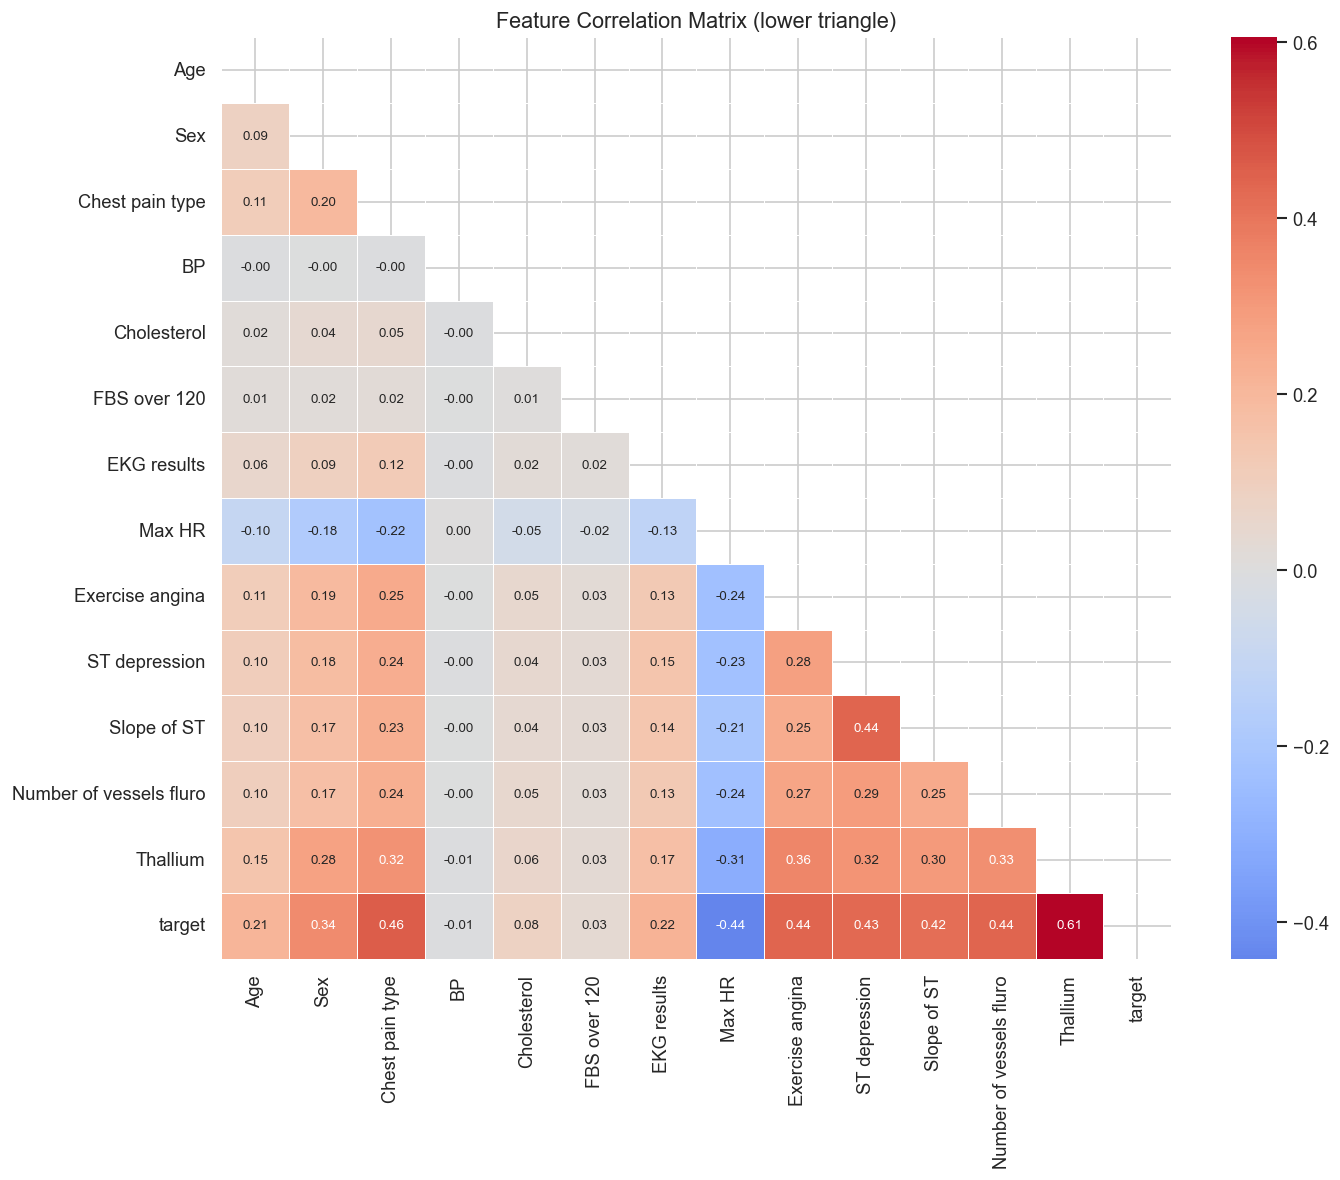

In [14]:
corr_cols = numeric_cols + ['target']
corr = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=ax, annot_kws={'size': 8})
ax.set_title('Feature Correlation Matrix (lower triangle)', fontsize=13)
plt.tight_layout()
plt.show()

### 3.4 · Target rate per categorical feature

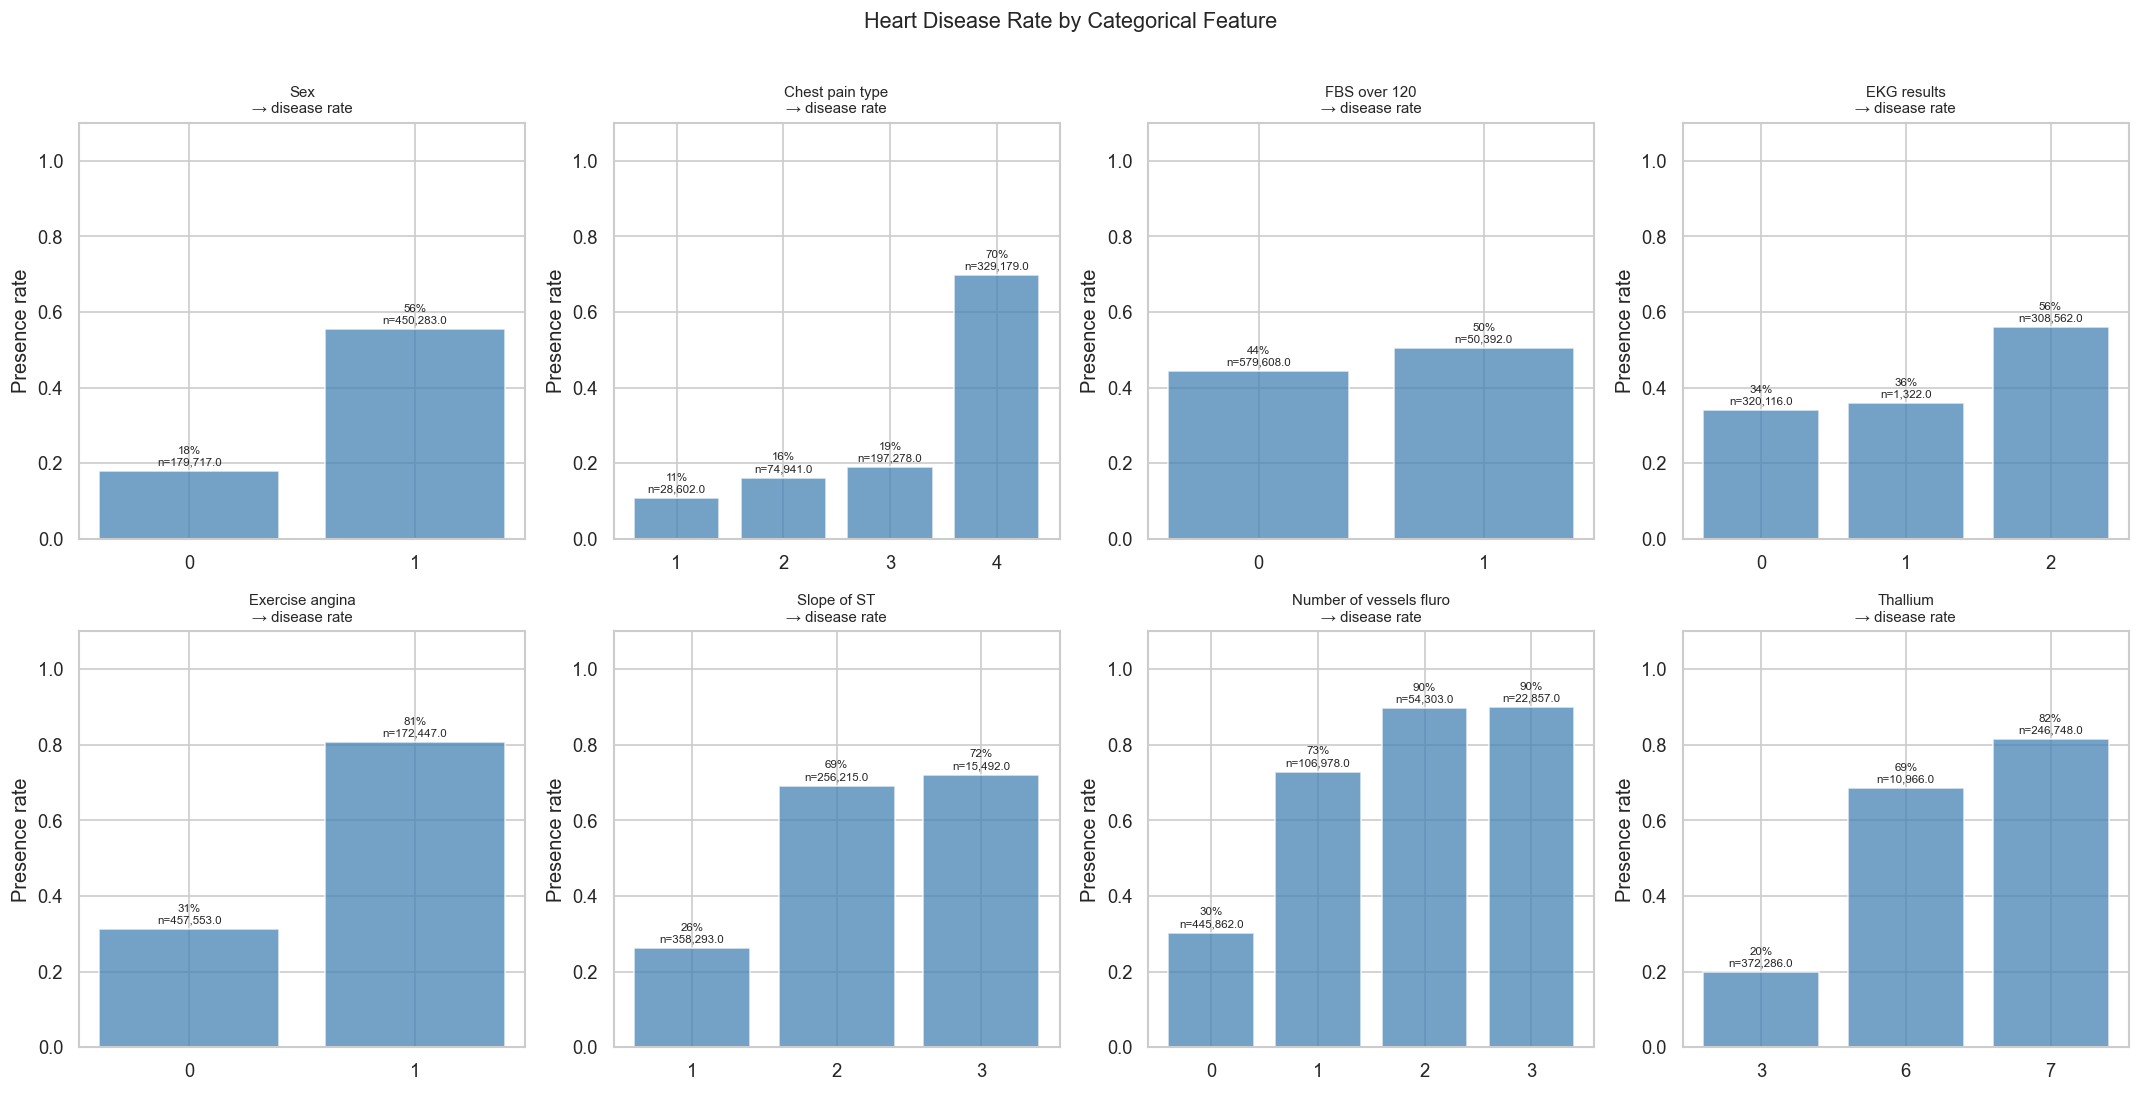

In [15]:
# Identify integer columns that behave as categoricals
pseudo_cat = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
               'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
pseudo_cat = [c for c in pseudo_cat if c in df.columns]

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for i, col in enumerate(pseudo_cat):
    rates = df.groupby(col)['target'].agg(['mean', 'count']).reset_index()
    bars = axes[i].bar(rates[col].astype(str), rates['mean'],
                        color='steelblue', alpha=0.75, edgecolor='white')
    for bar, (_, row) in zip(bars, rates.iterrows()):
        axes[i].text(bar.get_x() + bar.get_width()/2,
                     bar.get_height() + 0.01,
                     f'{row["mean"]:.0%}\nn={row["count"]:,}',
                     ha='center', va='bottom', fontsize=7)
    axes[i].set_title(f'{col}\n→ disease rate', fontsize=9)
    axes[i].set_ylim(0, 1.1)
    axes[i].set_ylabel('Presence rate')

plt.suptitle('Heart Disease Rate by Categorical Feature', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

---
## 4 · Gender-Stratified Analysis
### 4.1 · How many males vs females?

Sex value counts:
 Sex
1    450283
0    179717
Name: count, dtype: int64


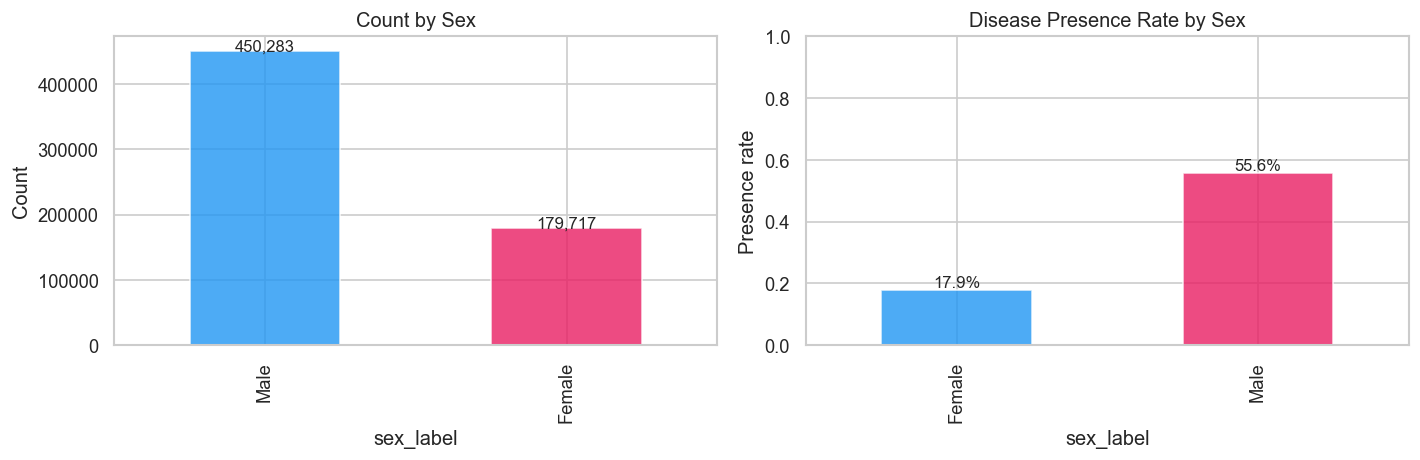

In [16]:
# Adjust 'Sex' encoding if needed — 1=Male, 0=Female is standard for this dataset
sex_map = df['Sex'].value_counts()
print('Sex value counts:\n', sex_map)

# Label for readability (adjust if 1≠Male in your encoding)
df['sex_label'] = df['Sex'].map({1: 'Male', 0: 'Female'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count
df['sex_label'].value_counts().plot(kind='bar', ax=axes[0],
                                     color=['#2196F3', '#E91E63'], alpha=0.8)
axes[0].set_title('Count by Sex')
axes[0].set_ylabel('Count')
for bar in axes[0].patches:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 f'{int(bar.get_height()):,}', ha='center', fontsize=10)

# Disease rate
rate = df.groupby('sex_label')['target'].mean()
rate.plot(kind='bar', ax=axes[1], color=['#2196F3', '#E91E63'], alpha=0.8)
axes[1].set_title('Disease Presence Rate by Sex')
axes[1].set_ylabel('Presence rate')
axes[1].set_ylim(0, 1)
for bar in axes[1].patches:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{bar.get_height():.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 4.2 · Feature distributions: Male vs Female side-by-side

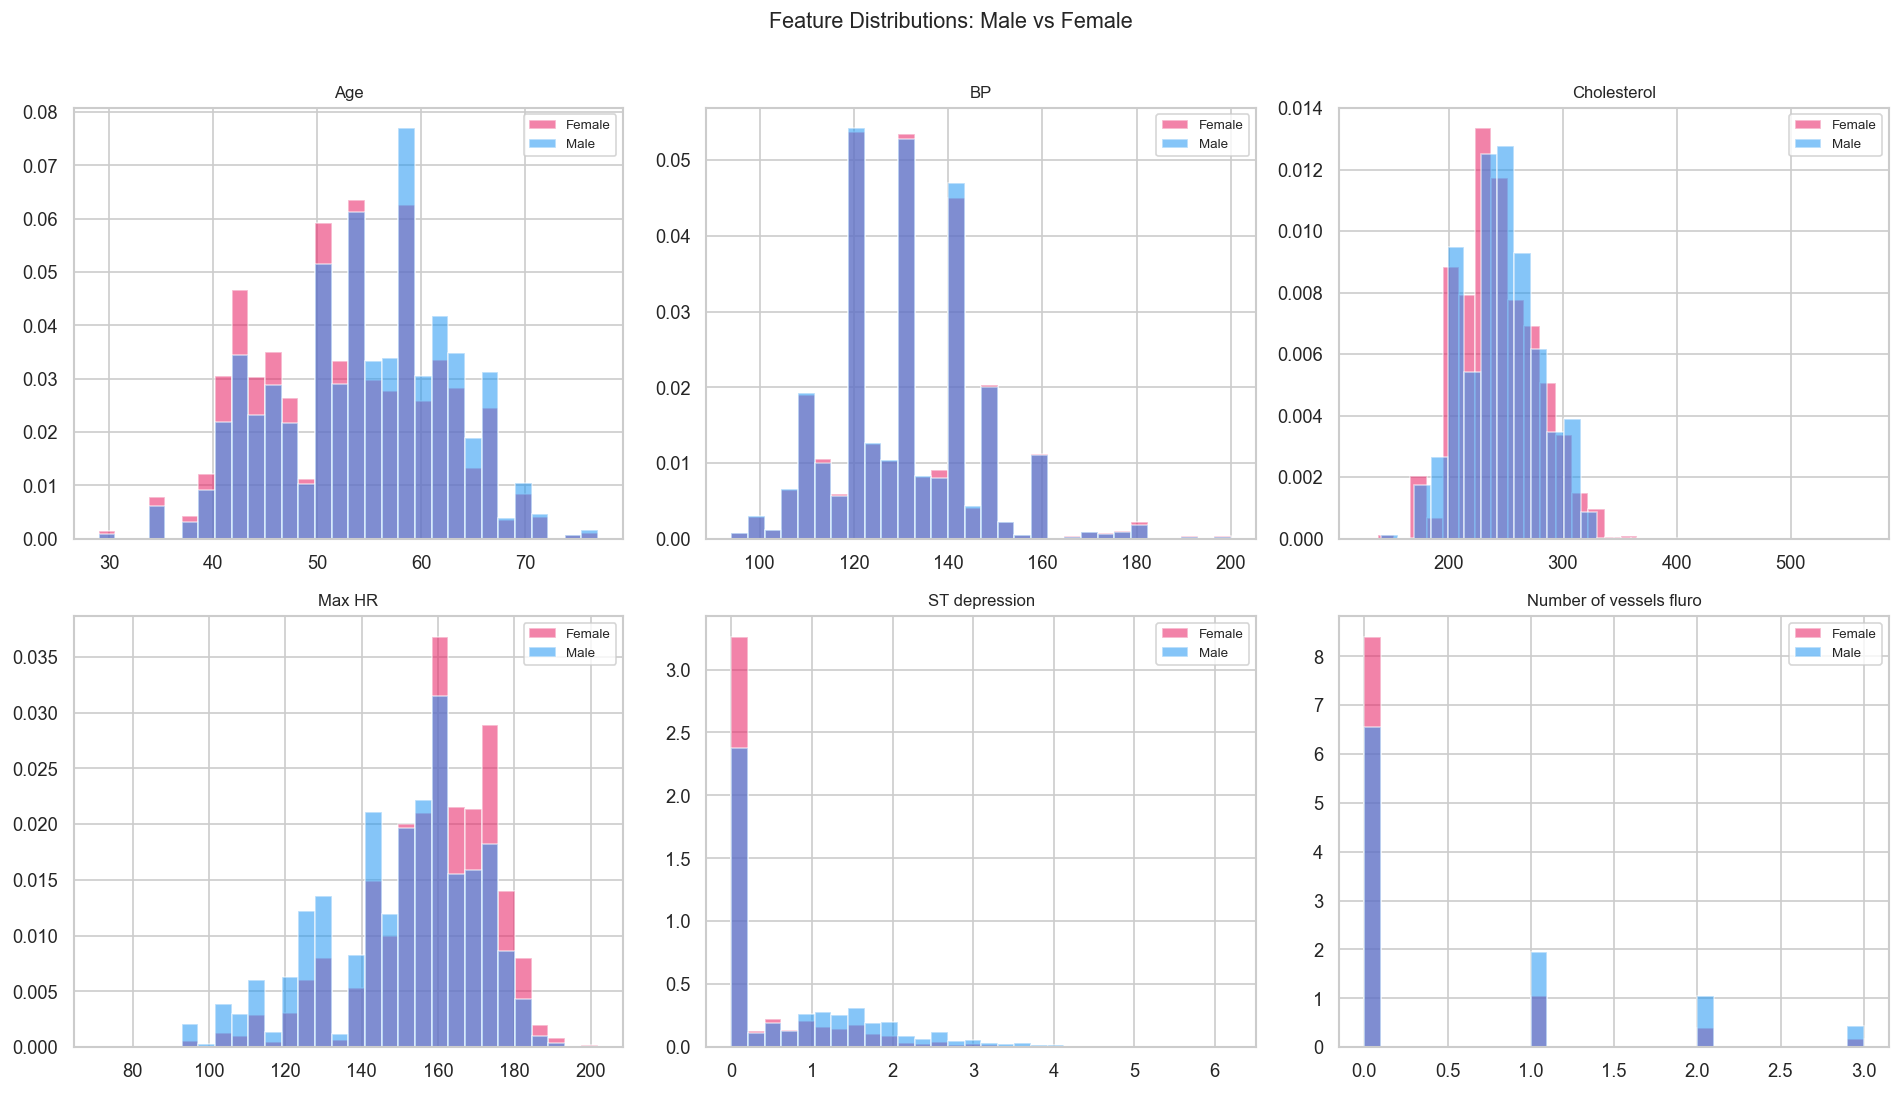

In [17]:
key_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']
key_features = [f for f in key_features if f in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()
colors = {'Male': '#2196F3', 'Female': '#E91E63'}

for i, col in enumerate(key_features):
    for sex, grp in df.groupby('sex_label'):
        axes[i].hist(grp[col].dropna(), bins=30, alpha=0.55,
                     color=colors.get(sex, 'grey'), label=sex, density=True)
    axes[i].set_title(col, fontsize=10)
    axes[i].legend(fontsize=8)

plt.suptitle('Feature Distributions: Male vs Female', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

### 4.3 · Disease rate per feature — stratified by sex
This tells us: do features predict disease *differently* for men vs women?

In [18]:
# Point-biserial correlation per sex group
from scipy.stats import pointbiserialr

results = []
for col in numeric_cols:
    for sex, grp in df.groupby('sex_label'):
        if grp[col].nunique() > 1:
            r, p = pointbiserialr(grp[col].fillna(grp[col].median()), grp['target'])
            results.append({'feature': col, 'sex': sex, 'correlation': round(r, 3), 'p_value': round(p, 4)})

corr_sex = pd.DataFrame(results).pivot(index='feature', columns='sex', values='correlation')
corr_sex['diff'] = (corr_sex['Male'] - corr_sex['Female']).abs()
corr_sex = corr_sex.sort_values('diff', ascending=False)

print('Point-biserial correlation with target, by sex:')
print(corr_sex.to_string())

Point-biserial correlation with target, by sex:
sex                      Female   Male   diff
feature                                      
Chest pain type           0.345  0.461  0.116
Slope of ST               0.333  0.401  0.068
Max HR                   -0.371 -0.423  0.052
EKG results               0.164  0.212  0.048
Age                       0.163  0.206  0.043
Exercise angina           0.379  0.414  0.035
ST depression             0.373  0.405  0.032
Cholesterol               0.056  0.080  0.024
Thallium                  0.551  0.570  0.019
FBS over 120              0.020  0.031  0.011
Number of vessels fluro   0.405  0.411  0.006
BP                       -0.001 -0.005  0.004


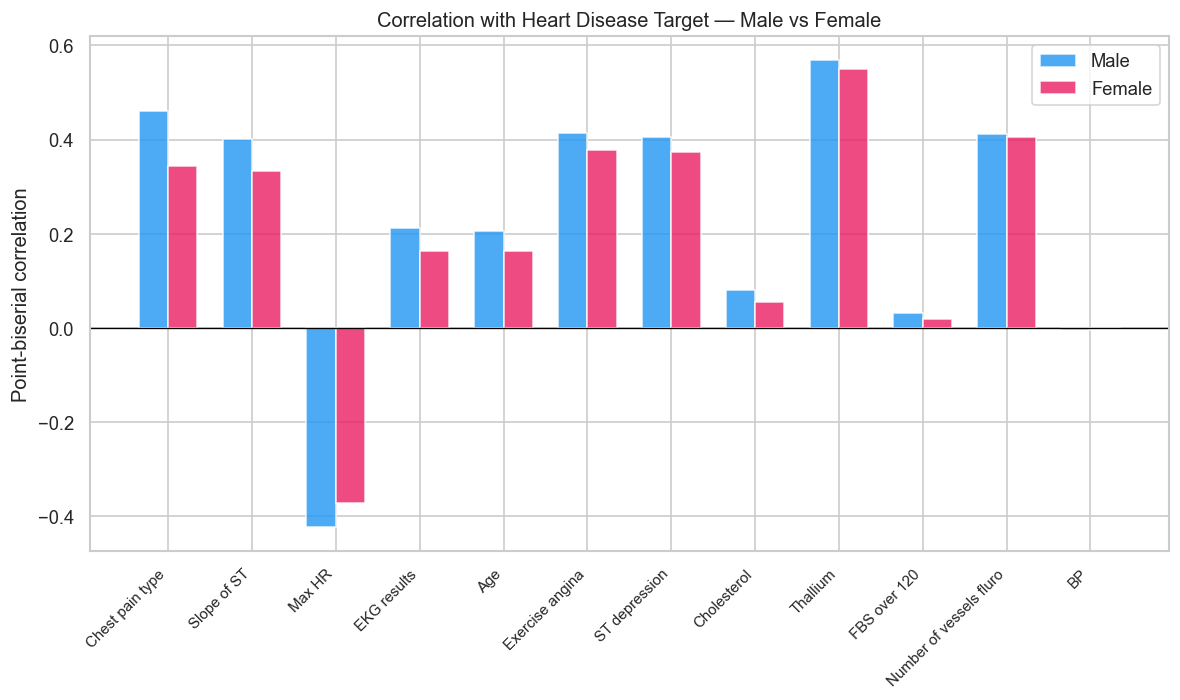

In [19]:
# Visual: correlation difference male vs female
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(corr_sex))
width = 0.35

bars1 = ax.bar(x - width/2, corr_sex['Male'], width, label='Male', color='#2196F3', alpha=0.8)
bars2 = ax.bar(x + width/2, corr_sex['Female'], width, label='Female', color='#E91E63', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(corr_sex.index, rotation=45, ha='right', fontsize=9)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Correlation with Heart Disease Target — Male vs Female', fontsize=12)
ax.set_ylabel('Point-biserial correlation')
ax.legend()
plt.tight_layout()
plt.show()

### 4.4 · Should we train separate models? — Decision framework

Key questions to answer:
1. **Is the female group large enough?** (<5k rows → risky to split)
2. **Do features predict differently by sex?** (large `diff` above → yes)
3. **Does a single model fail on one group?** (check AUC per sex in modeling phase)

In [20]:
# Quick assessment
sex_counts = df['sex_label'].value_counts()
print('=== Group Sizes ===')
for sex, n in sex_counts.items():
    print(f'  {sex}: {n:,} rows ({n/len(df)*100:.1f}%)')

female_n = sex_counts.get('Female', 0)
min_rows_to_split = 10000  # rule of thumb

print(f'\n=== Recommendation ===')
if female_n < min_rows_to_split:
    print(f'⚠️  Female group is small ({female_n:,} rows).')
    print('   → Splitting may hurt performance due to limited training data.')
    print('   → Consider: sex as a feature + sex×feature interactions instead.')
else:
    print(f'✅  Female group is large enough ({female_n:,} rows) to consider splitting.')
    print('   → Train one model on all data, one male-only, one female-only.')
    print('   → Compare AUC per sex — if gap is large, ensemble the sex-specific ones.')

print(f'\n=== Max correlation difference (Male vs Female) ===')
print(corr_sex.head(5)[['Male','Female','diff']].to_string())

=== Group Sizes ===
  Male: 450,283 rows (71.5%)
  Female: 179,717 rows (28.5%)

=== Recommendation ===
✅  Female group is large enough (179,717 rows) to consider splitting.
   → Train one model on all data, one male-only, one female-only.
   → Compare AUC per sex — if gap is large, ensemble the sex-specific ones.

=== Max correlation difference (Male vs Female) ===
sex               Male  Female   diff
feature                              
Chest pain type  0.461   0.345  0.116
Slope of ST      0.401   0.333  0.068
Max HR          -0.423  -0.371  0.052
EKG results      0.212   0.164  0.048
Age              0.206   0.163  0.043


### 4.5 · Proposed approach

Based on the analysis above, here's a practical plan:

**Option A — Single model + sex feature (recommended if female group < ~20% of data)**
- Add `Sex` and interaction features: `Sex × Age`, `Sex × Cholesterol`, etc.
- Model sees all data, doesn't lose signal from small female group

**Option B — Stratified training (if female group ≥ 15%)**
- Train 3 models: all data, male-only, female-only
- Generate predictions from all 3
- For test rows: use male model for males, female model for females
- Or blend: `0.4 × global + 0.6 × sex_specific`

**Option C — Post-hoc calibration**
- Train single model, then calibrate thresholds separately per sex using Platt scaling

---
## 5 · Cardiac Surveillance Proxy

We don't have an explicit 'history of cardiac disease' column, but we can infer it.
Patients **already in the system** tend to have:
- `Number of vessels fluro > 0` — fluoroscopy ordered because disease was suspected/known
- `Thallium == 6` — fixed defect = permanent scar tissue from a past cardiac event
- `EKG results == 2` — ST-T wave abnormality, indicative of ongoing or past disease

These patients are likely **medicated and monitored**, meaning their cholesterol, BP,
and Max HR values are artificially managed — carrying different meaning than in naive patients.

In [21]:
# ── Build the proxy flag ───────────────────────────────────────────────────
df['under_surveillance'] = (
    (df['Number of vessels fluro'] > 0) |
    (df['Thallium'] == 6) |
    (df['EKG results'] == 2)
).astype(int)

counts = df['under_surveillance'].value_counts()
print('Under surveillance (1) vs naive (0):')
for val, n in counts.items():
    label = 'Surveilled' if val == 1 else 'Naive     '
    print(f'  {label}: {n:,} ({n/len(df)*100:.1f}%)')

print(f'\nDisease rate — Surveilled: {df[df.under_surveillance==1]["target"].mean():.1%}')
print(f'Disease rate — Naive:      {df[df.under_surveillance==0]["target"].mean():.1%}')

Under surveillance (1) vs naive (0):
  Surveilled: 386,250 (61.3%)
  Naive     : 243,750 (38.7%)

Disease rate — Surveilled: 58.9%
Disease rate — Naive:      22.5%


### 5.1 · Feature correlations — Surveilled vs Naive

In [22]:
from scipy.stats import pointbiserialr

results = []
for col in numeric_cols:
    for grp_val, grp_name in [(0, 'Naive'), (1, 'Surveilled')]:
        grp = df[df['under_surveillance'] == grp_val]
        if grp[col].nunique() > 1:
            r, p = pointbiserialr(grp[col].fillna(grp[col].median()), grp['target'])
            results.append({'feature': col, 'group': grp_name,
                            'correlation': round(r, 3), 'p_value': round(p, 4)})

corr_surv = pd.DataFrame(results).pivot(index='feature', columns='group', values='correlation')
corr_surv['diff'] = (corr_surv['Surveilled'] - corr_surv['Naive']).abs()
corr_surv = corr_surv.sort_values('diff', ascending=False)
print(corr_surv.to_string())

group                    Naive  Surveilled   diff
feature                                          
EKG results             -0.000      -0.121  0.121
Chest pain type          0.356       0.473  0.117
Sex                      0.266       0.347  0.081
Slope of ST              0.324       0.395  0.071
Exercise angina          0.360       0.420  0.060
ST depression            0.345       0.402  0.057
Max HR                  -0.369      -0.423  0.054
Thallium                 0.530       0.580  0.050
Age                      0.171       0.207  0.036
Cholesterol              0.057       0.084  0.027
FBS over 120             0.017       0.033  0.016
BP                      -0.005      -0.003  0.002
Number of vessels fluro    NaN       0.402    NaN


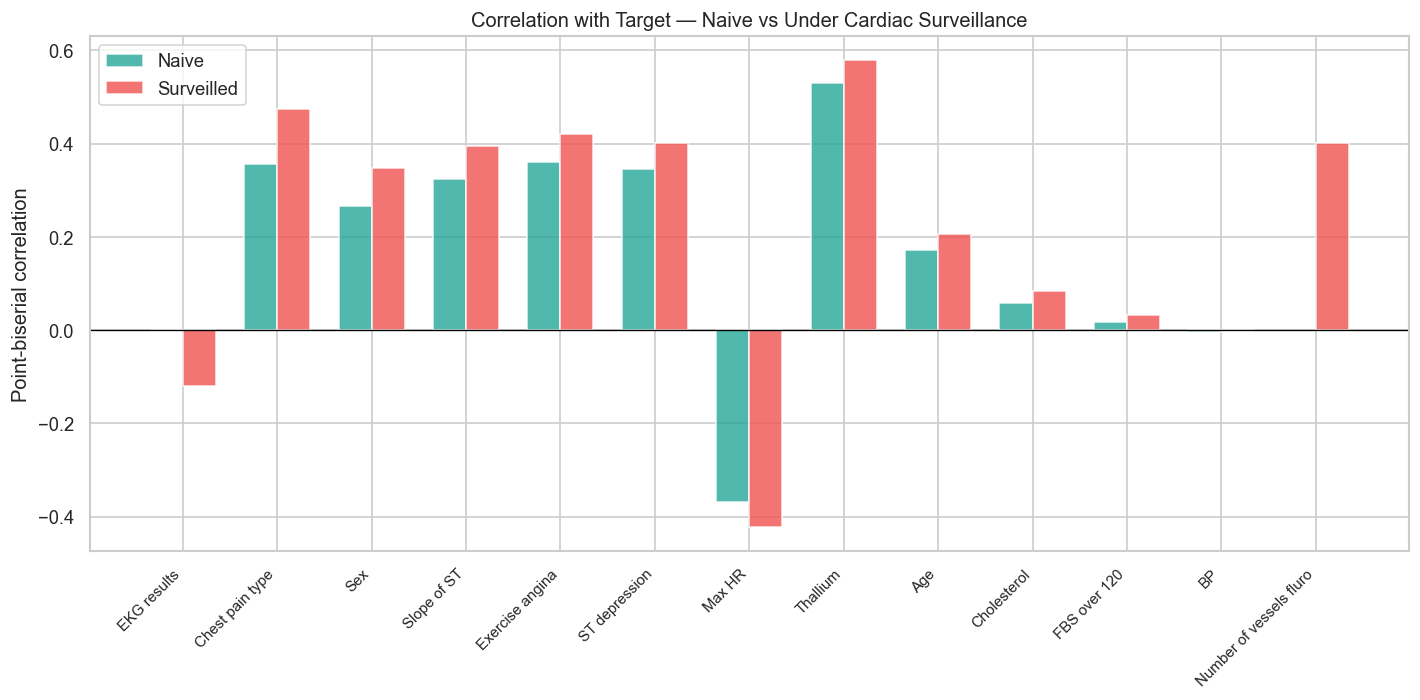

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(corr_surv))
width = 0.35

ax.bar(x - width/2, corr_surv['Naive'],       width, label='Naive',       color='#26A69A', alpha=0.8)
ax.bar(x + width/2, corr_surv['Surveilled'],  width, label='Surveilled',  color='#EF5350', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(corr_surv.index, rotation=45, ha='right', fontsize=9)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Correlation with Target — Naive vs Under Cardiac Surveillance', fontsize=12)
ax.set_ylabel('Point-biserial correlation')
ax.legend()
plt.tight_layout()
plt.show()

### 5.2 · The 4-group matrix: Sex × Surveillance

In [24]:
df['group'] = df['sex_label'] + ' / ' + df['under_surveillance'].map({0:'Naive', 1:'Surveilled'})

group_stats = df.groupby('group').agg(
    n         = ('target', 'count'),
    disease_rate = ('target', 'mean'),
    avg_cholesterol = ('Cholesterol', 'mean'),
    avg_max_hr  = ('Max HR', 'mean'),
    avg_bp      = ('BP', 'mean')
).round(3)
group_stats['n_pct'] = (group_stats['n'] / len(df) * 100).round(1)
print(group_stats.to_string())

                          n  disease_rate  avg_cholesterol  avg_max_hr   avg_bp  n_pct
group                                                                                 
Female / Naive        90432         0.080          242.222     160.313  130.601   14.4
Female / Surveilled   89285         0.278          243.720     155.954  130.553   14.2
Male / Naive         153318         0.310          244.060     155.812  130.567   24.3
Male / Surveilled    296965         0.683          246.742     148.045  130.414   47.1


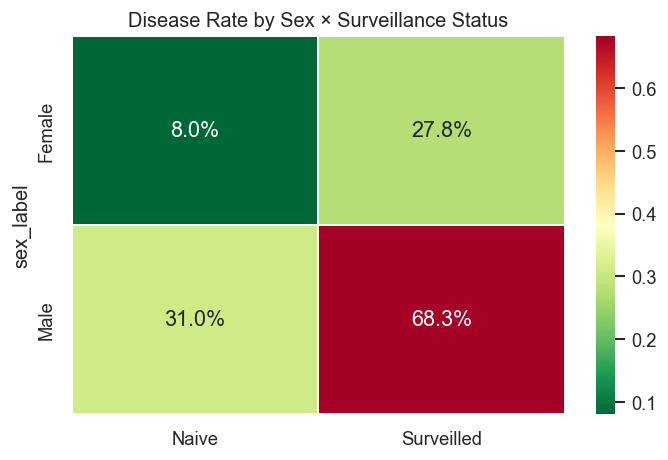

In [25]:
# Disease rate heatmap across the 4 groups
pivot = df.groupby(['sex_label', 'under_surveillance'])['target'].mean().unstack()
pivot.columns = ['Naive', 'Surveilled']

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt='.1%', cmap='RdYlGn_r',
            linewidths=1, ax=ax, annot_kws={'size': 13})
ax.set_title('Disease Rate by Sex × Surveillance Status', fontsize=12)
plt.tight_layout()
plt.show()

### 5.3 · Medicated feature shift — does treatment mask signals?

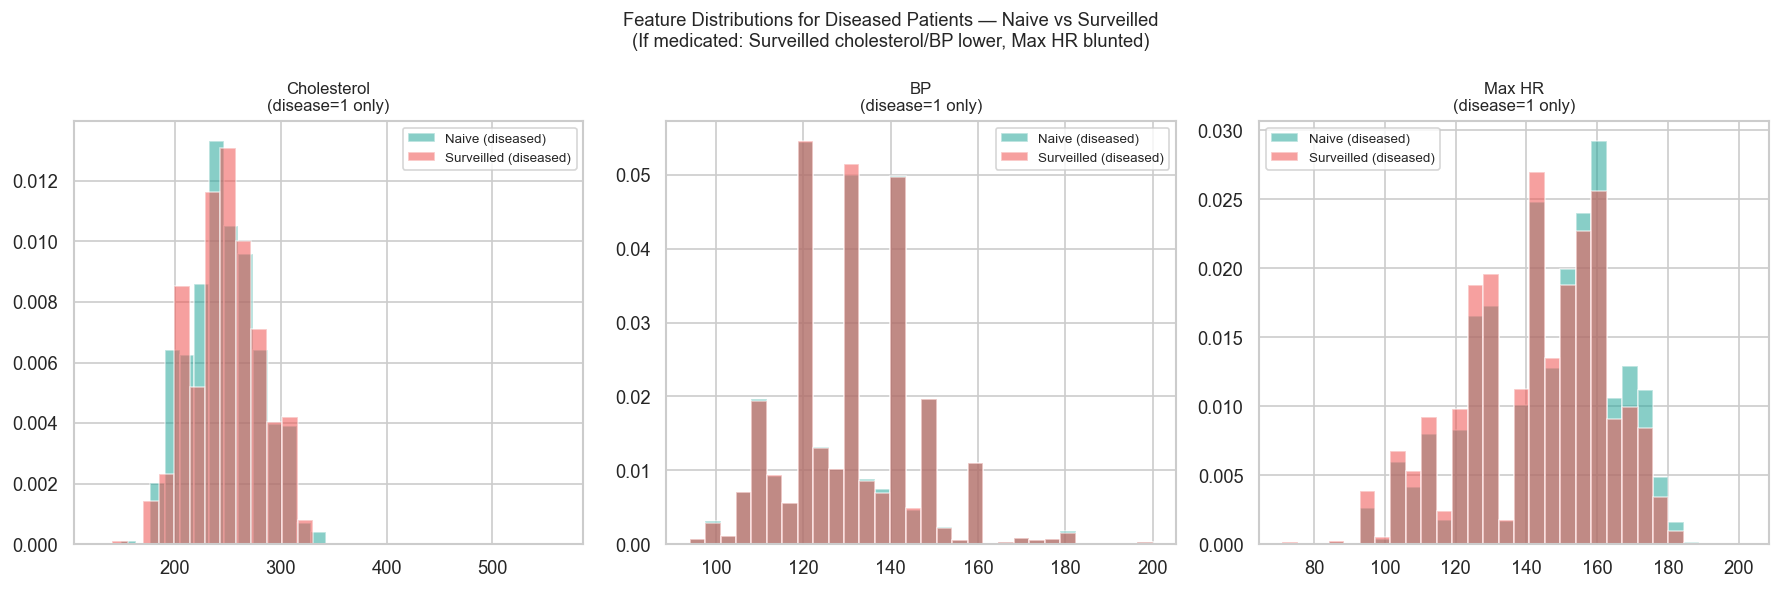

In [26]:
# For surveilled vs naive patients WITH disease — do key features look different?
# If medicated: cholesterol/BP should be lower, Max HR may be blunted
medicated_features = ['Cholesterol', 'BP', 'Max HR']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = {'Naive': '#26A69A', 'Surveilled': '#EF5350'}

for i, col in enumerate(medicated_features):
    for grp_val, grp_name in [(0, 'Naive'), (1, 'Surveilled')]:
        subset = df[(df['under_surveillance'] == grp_val) & (df['target'] == 1)][col]
        axes[i].hist(subset, bins=30, alpha=0.55, density=True,
                     color=colors[grp_name], label=f'{grp_name} (diseased)')
    axes[i].set_title(f'{col}\n(disease=1 only)', fontsize=10)
    axes[i].legend(fontsize=8)

plt.suptitle('Feature Distributions for Diseased Patients — Naive vs Surveilled\n'
             '(If medicated: Surveilled cholesterol/BP lower, Max HR blunted)', fontsize=11)
plt.tight_layout()
plt.show()

### 5.4 · Stratification decision

Based on the above:
- If **disease rates diverge sharply** across the 4 groups → stratified models make sense
- If **feature correlations shift significantly** in surveilled group → interactions needed
- If **cholesterol/BP/MaxHR distributions shift** for surveilled+diseased → medication masking confirmed

Candidate interaction features to engineer:
```python
df['surv_x_cholesterol'] = df['under_surveillance'] * df['Cholesterol']
df['surv_x_max_hr']      = df['under_surveillance'] * df['Max HR']
df['surv_x_bp']          = df['under_surveillance'] * df['BP']
df['sex_x_chest_pain']   = df['Sex'] * df['Chest pain type']
df['sex_x_slope']        = df['Sex'] * df['Slope of ST']
df['sex_x_max_hr']       = df['Sex'] * df['Max HR']
```

In [27]:
# Save final enriched dataset
df.drop(columns=['sex_label', 'group']).to_csv(BASE + 'train_clean.csv', index=False)
print('✅ Saved train_clean.csv with under_surveillance feature')
print(f'Final shape: {df.shape}')
print(f'Features: {list(df.columns)}')

✅ Saved train_clean.csv with under_surveillance feature
Final shape: (630000, 18)
Features: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'target', 'sex_label', 'under_surveillance', 'group']


## Section 6 · Group-Aware Evaluation & Bias Mitigation

### 6.1 · Sample weights — penalise female false negatives more

In [28]:
def get_sample_weight(row):
    if row['sex_label'] == 'Female' and row['under_surveillance'] == 0:
        return 4.0   # rarest + most historically underdiagnosed
    elif row['sex_label'] == 'Female' and row['under_surveillance'] == 1:
        return 2.0
    elif row['sex_label'] == 'Male' and row['under_surveillance'] == 0:
        return 1.5
    else:
        return 1.0   # Male/Surveilled — largest group, easiest to predict

df['sample_weight'] = df.apply(get_sample_weight, axis=1)
print(df.groupby('group')['sample_weight'].first())

group
Female / Naive         4.0
Female / Surveilled    2.0
Male / Naive           1.5
Male / Surveilled      1.0
Name: sample_weight, dtype: float64


### 6.2 · Group-aware evaluation function

In [30]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix

In [31]:
def evaluate_by_group(y_true, y_pred_proba, groups, threshold=0.5):
    """
    Evaluate model performance broken down by Sex × Surveillance group.
    y_true        : pd.Series of true labels
    y_pred_proba  : np.array of predicted probabilities
    groups        : pd.Series of group labels (e.g. 'Female / Naive')
    threshold     : classification threshold (global default)
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    results = []

    for group in sorted(groups.unique()):
        mask = groups == group
        yt, yp, ypp = y_true[mask], y_pred[mask], y_pred_proba[mask]

        tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
        results.append({
            'group':      group,
            'n':          mask.sum(),
            'prevalence': f'{yt.mean():.1%}',
            'AUC':        round(roc_auc_score(yt, ypp), 3),
            'Recall':     round(recall_score(yt, yp), 3),    # sensitivity — catch disease
            'Precision':  round(precision_score(yt, yp), 3),
            'FN':         fn,
            'FN_rate':    round(fn / (fn + tp), 3),           # false negative rate — key metric
        })

    result_df = pd.DataFrame(results).set_index('group')
    print(result_df.to_string())
    return result_df

### 6.3 · Per-group threshold optimisation (run AFTER training)

In [32]:
from sklearn.metrics import recall_score
import numpy as np

In [33]:
def optimise_thresholds(y_true, y_pred_proba, groups, min_recall=0.80):
    """
    Find the lowest threshold per group that achieves min_recall.
    Prioritises catching disease (recall) over precision.
    """
    thresholds = {}
    for group in sorted(groups.unique()):
        mask = groups == group
        yt, ypp = y_true[mask], y_pred_proba[mask]
        best_threshold = 0.5
        for t in np.arange(0.05, 0.75, 0.01):
            yp = (ypp >= t).astype(int)
            if yp.sum() > 0:  # avoid zero-prediction edge case
                rec = recall_score(yt, yp)
                if rec >= min_recall:
                    best_threshold = t
                    break  # lowest threshold that hits min_recall
        thresholds[group] = round(best_threshold, 2)
        print(f'{group}: threshold={best_threshold:.2f}')
    return thresholds

In [38]:
def predict_with_group_thresholds(y_pred_proba, groups, thresholds):
    y_pred = np.zeros(len(y_pred_proba), dtype=int)
    for group, threshold in thresholds.items():
        mask = (groups == group).values
        y_pred[mask] = (y_pred_proba[mask] >= threshold).astype(int)
    return y_pred

In [39]:
print(y_pred)

NameError: name 'y_pred' is not defined